In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seawater as sw
import cartopy
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def gaussian_windstress(nt=120, end_time=60, max_tau=0.1, sigma=1, center=3.5, angle_up=120.):
    '''nt=120  number of wind records
       end_time = 60  end time of records
       max_tau = 0.1  original 0.1
       sigma = 1 
       center = 3.5  base 3.5 hr, faster 2.5 hr, slower 4.5
       angle_up = 120. Rotation angle (in deg) to get alongshore winds'''
    
    t = np.linspace(0,end_time,nt)  #time array of wind records
    gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
    mask = t>center
    gauss[mask]=0
    windstress= gauss.copy()
    #alpha = np.radians(angle_up)
    #zonal_tau = windstress*np.cos(alpha)
    #merid_tau = windstress*np.sin(alpha)
    return(windstress, t)
    

In [3]:
# Base run (winter TS)
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

# summer TS run
outdirS = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/04_SVB_augTS_output/'
outdirS2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/04_noSVB_augTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
dsS = open_mdsdataset(outdirS, prefix=['eta','dynVars'], levels=levels)
dsS2 = open_mdsdataset(outdirS2, prefix=['eta','dynVars'], levels=levels)

In [4]:
# Get coastline points
df = pd.read_csv('../coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [5]:
nx = 512
ny = 612
nz = 100
nt = 720

In [6]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,nt)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

Lon -121.3, Lat 27.6 


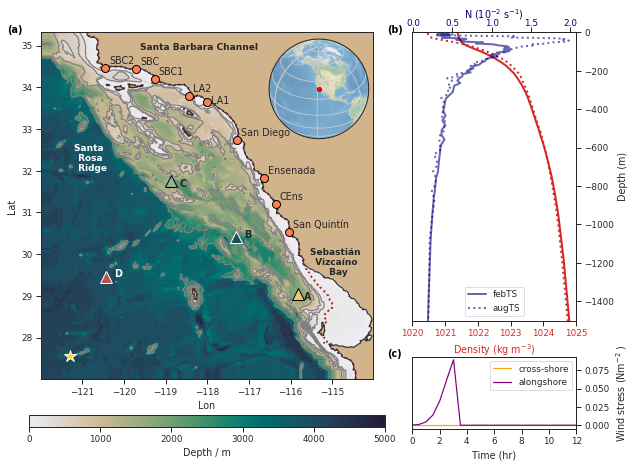

In [7]:
sns.set_style('ticks')
sns.set_context('paper')
fig = plt.figure(figsize=(7.6,5.0))
ax = fig.add_axes([-0.1, -0.15, 0.65, 1.25])
ax.set_facecolor('tan')

pc = ax.pcolormesh(lon,lat,dep_maskedSVB,
                  vmin=0, vmax=5000, cmap=cmo.cm.rain)
cb = plt.colorbar(pc, ax=ax, label='Depth / m',pad=0.08,
                  aspect=30, orientation='horizontal')

cn = ax.contour(lon,lat,dep_maskedSVB, colors=['0.5'], 
                levels=[250,500,1000,2000,3000])

ax.contour(lon,lat,depth[:,:], levels=[0], colors='brown', linestyles=':', linewidths=2)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_aspect(1)
    
for kk, lab in zip([47,100,150,230,307,335,400,440,450], 
                   ['San Quintín','CEns' ,'Ensenada','San Diego','LA1','LA2','SBC1','SBC','SBC2']):
    ii = int(lon_ii[kk])
    jj = int(lat_jj[kk])
    
    ax.plot(LON[0,ii],LAT[jj,0],'o', 
            markersize=8, color='coral', markeredgecolor='k')
    if lab == 'LA1':
        ax.text(LON[0,ii]+0.1,LAT[jj,0]-0.05, lab)
    else:
        ax.text(LON[0,ii]+0.1,LAT[jj,0]+0.1, lab)
       
ax.text(0.89,0.3,'Sebastián \n Vizcaíno \n Bay',fontsize=9, fontweight='demibold',horizontalalignment='center',
        transform=ax.transAxes)
#ax.text(0.78,0.41,'San Quintin, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.7,0.55,'Ensenada, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.62,0.67,'Tijuana, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.62,0.7,'San Diego, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.45,0.84,'Santa Monica, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.51,0.8,'Long Beach, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.3,0.95,'Santa Barbara Channel',fontsize=9, transform=ax.transAxes,
        fontweight='demibold')
ax.text(0.15,0.6,'Santa \n Rosa \n Ridge',color='w',fontsize=9, transform=ax.transAxes,
        fontweight='bold', horizontalalignment='center')

#---- Plot globe -------------------------
axins = inset_axes(ax, width="30%", height="30%", loc= 'upper right',
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Orthographic(central_latitude=32, 
                                                                            central_longitude=-118)))
axins.add_feature(cartopy.feature.OCEAN, zorder=0)
axins.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axins.gridlines()
axins.stock_img()
#axins.plot([lon[0]+360], [lat[0]],'ro', transform=cartopy.crs.Orthographic(-110, 35))
#axins.plot([ lon[-1]+360], [lat[-1]],'ro', transform=cartopy.crs.Orthographic(-120, 35))
axins.plot(lon, np.ones_like(lon)*27,'r.',transform=cartopy.crs.Orthographic(-118, 32))
axins.plot(lon, np.ones_like(lon)*35.3,'r.',transform=cartopy.crs.Orthographic(-118, 32))

# ------------- wind stress ---------------------------
ax2 = fig.add_axes([0.6, 0., 0.3, 0.2])
tau_along, t = gaussian_windstress()
ax2.plot(t,np.zeros_like(t), color='orange', label='cross-shore')
ax2.plot(t,tau_along, color='purple', label='alongshore')
ax2.set_xlabel('Time (hr)')
ax2.set_ylabel(r'Wind stress (Nm$^{-2}$ )')
ax2.yaxis.set_label_position("right")
ax2.set_xlim([0,12])
ax2.yaxis.tick_right()
ax2.legend()

# ------------- N and rho ---------------------------

alpha=2.E-4,
beta=7.4E-4,
rhoNil=999.8

#pden_feb = sw.pden(ds.SALT[0,:,100,100].data,ds.THETA[0,:,100,100].data,-ds.Z.data)
pden_feb = rhoNil*(np.ones(np.shape(ds.SALT[0,:,100,100].data)) - alpha*(ds.THETA[0,:,100,100].data) + beta*(ds.SALT[0,:,100,100].data))
N2_feb,q,pave_feb  = sw.bfrq(ds.SALT[0,:,100,100].data,ds.THETA[0,:,100,100].data,-ds.Z.data)

#pden_aug = sw.pden(dsS.SALT[0,:,100,100].data,dsS.THETA[0,:,100,100].data,-dsS.Z.data)
pden_aug = rhoNil*(np.ones(np.shape(dsS.SALT[0,:,100,100].data)) - alpha*(dsS.THETA[0,:,100,100].data) + beta*(dsS.SALT[0,:,100,100].data))
N2_aug,q,pave_aug  = sw.bfrq(dsS.SALT[0,:,100,100].data,dsS.THETA[0,:,100,100].data,-dsS.Z.data)

ax3 = fig.add_axes([0.6, 0.3, 0.3, 0.8])
color = 'tab:red'
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(r'Density (kg m$^{-3}$)',color=color)
ax3.plot(pden_feb,ds.Z.data,'-', color=color, label='winTS', alpha=1, linewidth=2)
ax3.plot(pden_aug,dsS.Z.data,':', color=color, label='sumTS', alpha=1, linewidth=2)

ax3.tick_params(axis='x', labelcolor=color)
ax3.set_ylim(-3000,0)
ax3.set_xlim(1020, 1025)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax4 = ax3.twiny() 
color = 'navy'
ax4.set_xlabel(r'N (10$^{-2}$ s$^{-1}$)', color=color, labelpad=0.5)
ax4.plot(100*np.sqrt(N2_feb),-pave_feb,'-', color=color, label='febTS', alpha=0.6, linewidth=2)
ax4.plot(100*np.sqrt(N2_aug),-pave_aug,':', color=color, label='augTS', alpha=0.6, linewidth=2)
ax4.tick_params(axis='x', labelcolor=color, pad=0)
ax4.set_ylim(-1500,0)
ax4.legend(loc=8)

#--- Plot location of Initial T and S profiles ----
ax.plot(LON[0,45],LAT[40,0], '*', color='gold', markersize=12, markeredgecolor='w')
print('Lon %1.1f, Lat %1.1f ' %(LON[0,45],LAT[40,0]))

#--- Plot w stations -----
pta = [100,180]
ptb = [395,150]
ptc = [200,350]
ptd = [300,250]
colors = [ "#b75347", "#edc775", "#94b594", "#224b5e"]
ax.plot(lon[pta[0]], lat[pta[1]], '^', color=colors[0],
         markeredgecolor='1', markersize=12)
ax.plot(lon[ptb[0]], lat[ptb[1]], '^', color=colors[1],
         markeredgecolor='0', markersize=12)
ax.plot(lon[ptc[0]], lat[ptc[1]], '^', color=colors[2],
         markeredgecolor='0', markersize=12)
ax.plot(lon[ptd[0]], lat[ptd[1]], '^', color=colors[3],
         markeredgecolor='1', markersize=12)

ax.text(lon[pta[0]]+0.2, lat[pta[1]], 'D', fontweight='bold', color='w')
ax.text(lon[ptb[0]]+0.15, lat[ptb[1]]-0.15, 'A', fontweight='bold')
ax.text(lon[ptc[0]]+0.2, lat[ptc[1]]-0.15, 'C', fontweight='bold')
ax.text(lon[ptd[0]]+0.2, lat[ptd[1]], 'B', fontweight='bold')

ax.text(-0.1, 1, '(a)', fontweight='bold', color='k', 
        transform=ax.transAxes)
ax2.text(-0.15,1, '(c)', fontweight='bold', 
         color='k',transform=ax2.transAxes)
ax3.text(-0.15,1, '(b)', fontweight='bold', 
         color='k',transform=ax3.transAxes)

plt.savefig('figure1.png', dpi=500, bbox_inches='tight')

Text(0.22, 0.92, 'Canal de Santa Bárbara')

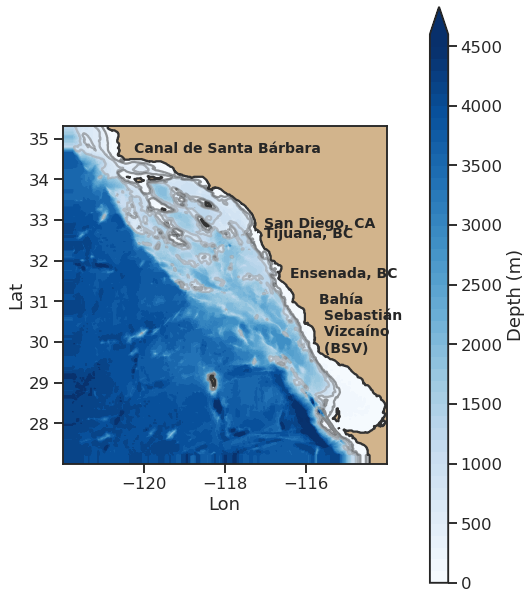

In [8]:
sns.set_style('ticks')
sns.set_context('talk')
fig = plt.figure(figsize=(8,10))

ax = fig.add_axes([0.1, 0.0, 0.75, 0.8])
ax.set_facecolor('tan')

pc = ax.contourf(lon,lat,dep_maskedSVB, 50,
                  vmin=0,vmax=4500,  cmap='Blues', extend='max')
cb = plt.colorbar(pc, ax=ax, label='Depth (m)',pad=0.1, aspect=30)

cn = ax.contour(lon,lat,dep_maskedSVB, alpha=0.5, 
                levels=[200,500,1000], colors=['0.2','0.4','0.6'])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

ax.set_aspect(1)

ax.text(0.79,0.33,'Bahía \n Sebastián \n Vizcaíno \n (BSV)',fontsize=14, fontweight='bold',
        transform=ax.transAxes)
#ax.text(0.78,0.41,'San Quintin, BC',fontsize=12, transform=ax.transAxes,fontweight='bold')
ax.text(0.7,0.55,'Ensenada, BC',fontsize=14, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.67,'Tijuana, BC',fontsize=14, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.7,'San Diego, CA',fontsize=14, transform=ax.transAxes,fontweight='bold')
#ax.text(0.45,0.84,'Santa Monica, CA',fontsize=12, transform=ax.transAxes,fontweight='bold')
ax.text(0.22,0.92,'Canal de Santa Bárbara',fontsize=14, transform=ax.transAxes,
        fontweight='bold')


In [9]:
print('%f' %lon[0])

-121.992200


In [10]:
-121.99 + 360

238.01

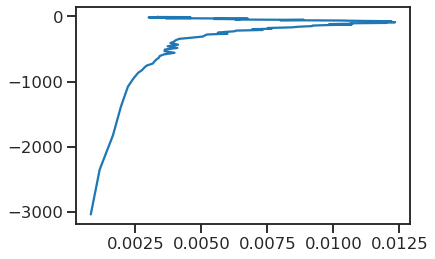

In [11]:
plt.plot(np.sqrt(N2_feb),-pave_feb)


In [12]:
for n,d in zip(N2_feb, Z):
    print('%f,%f' %(np.sqrt(n),d))

0.003343,-3.000000
0.003343,-5.000000
0.003344,-7.000000
0.004578,-9.000000
0.003124,-11.100000
0.003000,-13.400000
0.004045,-15.900000
0.003906,-18.600000
0.004609,-21.500000
0.003638,-24.600000
0.005466,-27.950000
0.006754,-31.600000
0.005475,-35.600000
0.006465,-39.950000
0.006289,-44.600000
0.008877,-49.500000
0.007982,-54.500000
0.010253,-59.500000
0.010898,-64.500000
0.011988,-69.500000
0.012202,-74.500000
0.011573,-79.750000
0.012336,-85.250000
0.011508,-90.750000
0.012000,-96.250000
0.010652,-101.750000
0.010718,-107.500000
0.009839,-113.750000
0.010686,-120.500000
0.009794,-127.750000
0.009205,-135.500000
0.009191,-143.750000
0.008677,-152.600000
0.008416,-162.200000
0.007512,-172.200000
0.007664,-182.200000
0.006919,-192.200000
0.007318,-202.200000
0.006301,-212.200000
0.006261,-222.200000
0.005863,-232.700000
0.005619,-244.200000
0.005986,-256.700000
0.005207,-270.200000
0.005127,-284.700000
0.005055,-300.200000
0.004633,-316.700000
0.004161,-334.200000
0.004033,-353.200000


In [13]:
## Vertical resolution vs changes in T, S and rho
## How abrupt are the changes in T, S and rho compared to the vertical spacing?

drF = ds2['drF'][:]
drC = ds2['drC'][:]
dT = np.diff(ds2['THETA'][0,:,100,100].data)
dS = np.diff(ds2['SALT'][0,:,100,100].data)


In [14]:
dz = [2, 2, 2, 2, 2, 2.2, 2.4, 2.6, 2.8,
       3.0, 3.2, 3.5, 3.8, 4.2, 4.5, 4.8, 5, 5, 5,
       5, 5, 5, 5.5, 5.5, 5.5, 5.5, 5.5, 6, 6.5,
       7, 7.5, 8, 8.5, 9.2, 10, 10, 10, 10, 10, 10,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 20,
       22, 23, 25, 25, 25, 25, 25, 25, 25, 25,
       27, 28, 30, 30, 32, 34, 36, 38, 40, 43,
       46, 50, 55, 59, 65, 70, 75, 80, 85, 92,
       100, 100, 100, 100, 100, 100, 105, 115, 125, 132,
       145, 160, 170, 180, 190, 200, 210, 230, 245, 269.8]
model_depth_4 = -1*np.array([2.0000e+00, 4.0000e+00, 6.0000e+00, 8.0000e+00,
               1.0000e+01, 1.2200e+01, 1.4600e+01, 1.7200e+01, 2.0000e+01,
               2.3000e+01, 2.6200e+01, 2.9700e+01, 3.3500e+01, 3.7700e+01,
               4.2200e+01, 4.7000e+01, 5.2000e+01, 5.7000e+01, 6.2000e+01,
               6.7000e+01, 7.2000e+01, 7.7000e+01, 8.2500e+01, 8.8000e+01,
               9.3500e+01, 9.9000e+01, 1.0450e+02, 1.1050e+02, 1.1700e+02,
               1.2400e+02, 1.3150e+02, 1.3950e+02, 1.4800e+02, 1.5720e+02,
               1.6720e+02, 1.7720e+02, 1.8720e+02, 1.9720e+02, 2.0720e+02,
               2.1720e+02, 2.2720e+02, 2.3820e+02, 2.5020e+02, 2.6320e+02,
               2.7720e+02, 2.9220e+02, 3.0820e+02, 3.2520e+02, 3.4320e+02,
               3.6320e+02, 3.8520e+02, 4.0820e+02, 4.3320e+02, 4.5820e+02,
               4.8320e+02, 5.0820e+02, 5.3320e+02, 5.5820e+02, 5.8320e+02,
               6.0820e+02, 6.3520e+02, 6.6320e+02, 6.9320e+02, 7.2320e+02,
               7.5520e+02, 7.8920e+02, 8.2520e+02, 8.6320e+02, 9.0320e+02,
               9.4620e+02, 9.9220e+02, 1.0422e+03, 1.0972e+03, 1.1562e+03,
               1.2212e+03, 1.2912e+03, 1.3662e+03, 1.4462e+03, 1.5312e+03,
               1.6232e+03, 1.7232e+03, 1.8232e+03, 1.9232e+03, 2.0232e+03,
               2.1232e+03, 2.2232e+03, 2.3282e+03, 2.4432e+03, 2.5682e+03,
               2.7002e+03, 2.8452e+03, 3.0052e+03, 3.1752e+03, 3.3552e+03,
               3.5452e+03, 3.7452e+03, 3.9552e+03, 4.1852e+03, 4.4302e+03,
               4.7000e+03])

tRef=np.array([16.05,16.04,16.03,16.02,16.0,15.99,15.98,15.96,15.94,15.91,
      15.89,15.84,15.79,15.73,15.64,15.55,15.4,15.25,15.0,14.75,14.4,14.05,13.68,
      13.29,12.95,12.61,12.3,11.99,11.67,11.33,10.99,10.67,10.36,10.06,
      9.81,9.6,9.42,9.26,9.11,9.0,8.88,8.77,8.66,8.54,8.43,8.31,8.18,
      8.03,7.86,7.68,7.49,7.3,7.11,6.92,6.73,6.55,6.37,6.19,
      6.01,5.84,5.66,5.48,5.3,5.12,4.96,4.8,4.64,4.49,
      4.34,4.19,4.04,3.88,3.73,3.57,3.4,3.23,3.07,2.91,2.75,
      2.61,2.47,2.32,2.18,2.06,2.0,1.96,1.92,1.88,1.83,1.78,
      1.73,1.67,1.63,1.59,1.54,1.5,1.46,1.43,1.39,1.39])
sRef=np.array([33.52,33.52,33.52,33.52,33.52,33.52,33.52,33.52,33.52,33.52,33.52,
      33.52,33.53,33.53,33.53,33.53,33.54,33.54,33.54,33.55,33.55,33.56,33.56,33.57,
      33.58,33.6,33.61,33.63,33.64,33.67,33.69,33.71,33.74,33.77,33.81,
      33.84,33.88,33.91,33.95,33.98,34.01,34.04,34.07,34.11,34.14,34.17,
      34.2,34.22,34.23,34.24,34.25,34.26,34.28,34.29,34.31,34.32,34.33,
      34.35,34.36,34.37,34.38,34.39,34.4,34.41,34.42,34.43,34.44,34.45,
      34.46,34.47,34.48,34.49,34.5,34.51,34.52,34.53,34.54,34.56,
      34.57,34.58,34.59,34.61,34.62,34.63,34.64,34.65,34.66,34.67,34.68,
      34.68,34.68,34.68,34.68,34.69,34.69,34.7,34.7,34.71,34.71,34.69])
tRef_aug = np.array([21.31,21.3,21.28,21.27,21.25,21.24,21.22,21.13,20.91,20.67,20.41,
                     19.84,19.18,18.45,17.64,16.78,16.1,15.42,14.87,14.32,13.87,13.43,
                     13.04,12.63,12.28,11.94,11.64,11.34,11.04,10.73,10.43,10.18,9.95,
                     9.74,9.54,9.37,9.22,9.08,8.95,8.85,8.76,8.67,8.57,8.46,8.33,8.19,
                     8.04,7.88,7.72,7.55,7.38,7.19,7.02,6.84,6.67,6.49,6.33,6.18,6.03,
                     5.89,5.75,5.61,5.46,5.31,5.16,5.0,4.84,4.68,4.52,4.37,4.23,4.09,3.94,
                     3.79,3.62,3.46,3.29,3.12,2.94,2.79,2.65,2.5,2.35,2.2,2.09,2.02,1.95,
                     1.88,1.81,1.75,1.68,1.61,1.57,1.53,1.5,1.47,1.44,1.4,1.38,1.48,])
sRef_aug = np.array([33.71,33.71,33.7,33.7,33.7,33.7,33.7,33.69,33.68,33.66,
                     33.64,33.61,33.59,33.56,33.55,33.54,33.54,33.54,33.54,33.55,
                     33.56,33.57,33.59,33.6,33.63,33.65,33.68,33.71,33.74,33.78,
                     33.81,33.85,33.89,33.92,33.96,33.99,34.03,34.07,34.1,34.12,34.15,
                     34.16,34.18,34.2,34.21,34.23,34.24,34.25,34.25,34.26,34.27,34.28,
                     34.29,34.31,34.33,34.35,34.36,34.37,34.38,34.4,34.4,34.41,34.42,34.42,
                     34.43,34.44,34.44,34.45,34.46,34.47,34.48,34.49,34.49,34.5,34.52,34.53,
                     34.54,34.55,34.56,34.57,34.58,34.59,34.6,34.61,34.62,34.63,34.65,34.66,
                     34.67,34.68,34.68,34.68,34.68,34.69,34.69,34.7,34.7,34.71,34.72,34.69])

In [25]:
alpha=2.E-4,
beta=7.4E-4,
rhoNil=999.8
rho = rhoNil*(np.ones(np.shape(tRef[...])) - alpha*(tRef[...]) + beta*(sRef[...]))
pden_win = sw.pden(sRef,tRef,model_depth_4)

rho_aug = rhoNil*(np.ones(np.shape(tRef_aug)) - alpha*(tRef_aug[...]) + beta*(sRef_aug[...]))
pden_sum = sw.pden(sRef_aug,tRef_aug,model_depth_4)

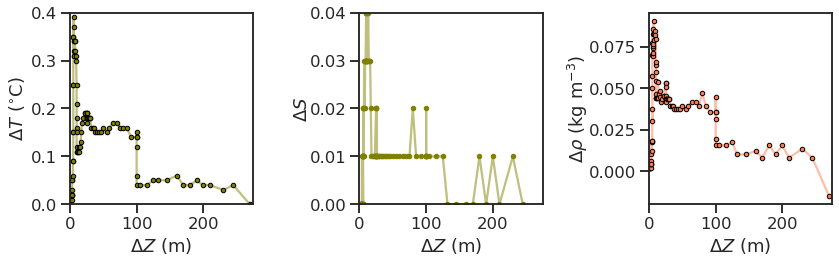

In [26]:
fig,(ax,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax.plot(np.diff(-model_depth_4),np.diff(-tRef), '-', color='olive', alpha=0.5)
ax.plot(np.diff(-model_depth_4),np.diff(-tRef), '.', color='olive', markeredgecolor='k')

ax.set_ylabel(r'$\Delta T$ ($^{\circ}$C)')
ax.set_xlabel(r'$\Delta Z$ (m)')
ax.set_xlim(0,275)
ax.set_ylim(0,0.4)

ax2.plot(np.diff(-model_depth_4),np.diff(sRef), '-', color='olive', alpha=0.5)
ax2.plot(np.diff(-model_depth_4),np.diff(sRef), '.', color='olive')
ax2.set_ylabel(r'$\Delta S$ ',labelpad=-0.5)
ax2.set_xlabel(r'$\Delta Z$ (m)')
ax2.set_xlim(0,275)
ax2.set_ylim(0,0.04)

ax3.plot(np.diff(-model_depth_4),np.diff(rho), '-', color='coral', alpha=0.5)
ax3.plot(np.diff(-model_depth_4),np.diff(rho), '.', color='coral', markeredgecolor='k')
#ax3.plot(np.diff(-model_depth_4),np.diff(pden_win), '-', color='coral', alpha=0.5)
#ax3.plot(np.diff(-model_depth_4),np.diff(pden_win), '.', color='coral', alpha=0.5)

ax3.set_ylabel(r'$\Delta \rho$ (kg$~$m$^{-3}$)',labelpad=-0.5)
ax3.set_xlabel(r'$\Delta Z$ (m)')
ax3.set_xlim(0,275)

plt.tight_layout()
plt.show()

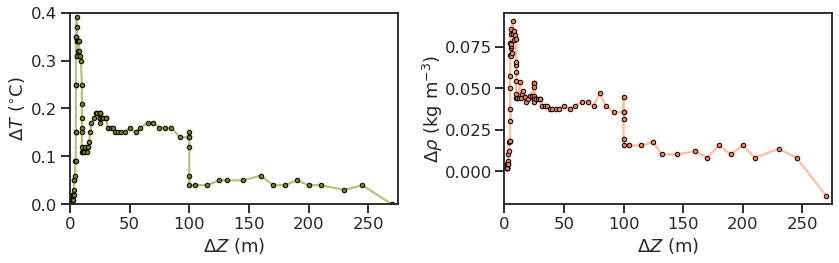

In [27]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(12,4))
ax.plot(np.diff(-model_depth_4),np.diff(-tRef), '-', color='olive', alpha=0.5)
ax.plot(np.diff(-model_depth_4),np.diff(-tRef), '.', color='olive', markeredgecolor='k')

ax.set_ylabel(r'$\Delta T$ ($^{\circ}$C)')
ax.set_xlabel(r'$\Delta Z$ (m)')
ax.set_xlim(0,275)
ax.set_ylim(0,0.4)

ax2.plot(np.diff(-model_depth_4),np.diff(rho), '-', color='coral', alpha=0.5)
ax2.plot(np.diff(-model_depth_4),np.diff(rho), '.', color='coral', markeredgecolor='k')
ax2.set_ylabel(r'$\Delta \rho$ (kg$~$m$^{-3}$)',labelpad=-0.5)
ax2.set_xlabel(r'$\Delta Z$ (m)')
ax2.set_xlim(0,275)

plt.tight_layout()
plt.show()

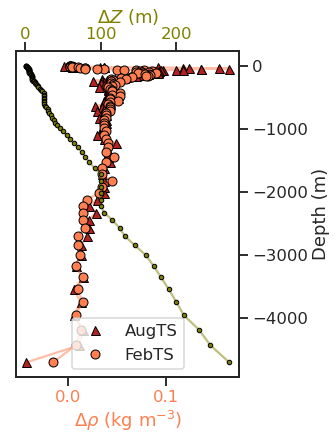

In [28]:
fig,(ax) = plt.subplots(1,1,figsize=(4,6))
color = 'coral'
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'$\Delta \rho$ (kg m$^{-3}$)',color=color)
ax.plot(np.diff(rho_aug),model_depth_4[1:], '-', color=color, alpha=0.5)
ax.plot(np.diff(rho_aug),model_depth_4[1:],'^', color='firebrick', markeredgecolor='k', label='AugTS')
ax.plot(np.diff(rho),model_depth_4[1:], '-', color=color, alpha=0.5)
ax.plot(np.diff(rho),model_depth_4[1:],'o', color=color, markeredgecolor='k', label='FebTS')
ax.tick_params(axis='x', labelcolor=color)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax2 = ax.twiny() 
color = 'olive'
ax2.set_xlabel(r'$\Delta Z$ (m)', color=color)
ax2.plot(np.diff(-model_depth_4),model_depth_4[1:], '-', color=color, alpha=0.5)
ax2.plot(np.diff(-model_depth_4),model_depth_4[1:], '.', color=color, markeredgecolor='k')
ax2.tick_params(axis='x', labelcolor=color, pad=0)
ax.legend(loc=8)
plt.savefig('Supp_vert_res.png', dpi=500, bbox_inches='tight')

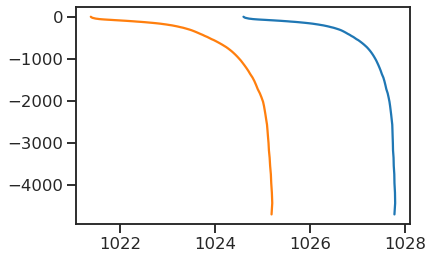

In [30]:
plt.plot(pden_win, model_depth_4)
plt.plot(rho, model_depth_4)